In [ ]:
################### TO DO's ########################


# - Erklärungen hinzufügen: Was wurde warum gemacht
# - Bitte alle Blöcke durchlaufen lassen, auf Fehler kontrollieren und ggf. korrigieren. 
# - Textanalysen durchführen: 
#     evtl. wieder für einen Beispielartikel? -> abhängig von Analyse!
#     Feature Selection / Engineering
#     evtl. noch hinzufügen via api: Kategorie
#     ...

# Text Analyses

In the basic analysis, we were able to gain a basic overview of the data package.  
With the following text analysis we want to compare how the history of the articles has affected the text. To do this, we compare the original version of the text (initial creation) with the most recently available version of the same article. 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup
import requests
import datetime
import re
import urllib
import shutil
import matplotlib.image as mpimg
import time
import crawlerlib as cl
import wikipedia
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import matplotlib as mpl
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

### Preparation

For our text analysis we have extended the crawlerlib with some functions: 

**Original Wiki-URL**

get whole url of first articleversion with pagetitle (wikititle)

In [2]:
def getOldSoup(wikititle):
	soup = requests.get("https://en.wikipedia.org/w/index.php?title="+wikititle+"&dir=prev&action=history")
	soup = BeautifulSoup(soup.content, 'html.parser')
	soup = soup.findAll("a", {"class": "mw-changeslist-date"})[0]['href']
	return 'https://en.wikipedia.org/'+soup

**Recent Wiki-URL**

get whole url of recent articleversion with pagetitle (wikititle)

In [3]:
def getRecentSoup(wikititle):
	wiki = 'https://en.wikipedia.org/wiki/'
	recent = wiki+wikititle
	return recent

**Wiki-Texts**

get original text and recent text per article

In [4]:
def getTextDF(urlis):
    textdf = pd.DataFrame(columns=['page_title', 'original', 'recent'])
    for i in range(len(urlis)):
        if str(getTextBody(urlis[i][0])).startswith('Redirect to'):
            continue
        else:
            s1 = str(getTextBody(urlis[i][0]))
            s2 = str(getTextBody(urlis[i][1]))
            textdf = textdf.append({'page_title' : str.rsplit(urlis[i][1], '/', 1)[-1], 'original' : s1, 'recent' : s2}, ignore_index=True)
    return textdf

**Vocabulary Density**

get vocabularity density for given text

In [5]:
def getVD(text):
  tokens = nltk.word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  nn = []
  ok = 'NN' 
  for i in tagged:
    if ok == i[1]:
      nn.append(i[0])
  nn1 = [re.sub('[^a-zA-Z0-9]+', '', _) for _ in nn]
  nn2 = []
  for i in nn1:
    if len(i) > 2:
      nn2.append(i)
    else:
      nn2.append('no text')
  try:
    VD = len(np.unique(nn2)) / len(nn2)
  except ZeroDivisionError:
    VD = 1
  return VD

**Words per Sentence**

get words per sentence for given text

In [6]:
def getWPS(text):
  tokens = nltk.word_tokenize(text)
  words = tokens
  sentences = [[]]
  ends = set(".?!;:")
  for word in words:
    if word in ends: 
      sentences.append([])
    else: 
      sentences[-1].append(word)
  if sentences[0]:
    if not sentences[-1]: sentences.pop()
    wps = sum(len(s) for s in sentences)/len(sentences)
    #print("average words per sentence: ", wps)
    return wps

**Words per Text**

get words per text for given text

In [7]:
def getWPT(text):
    tokens = nltk.word_tokenize(text)
    words = tokens
    sentences = [[]]
    for word in words:
        sentences.append([word])
    wpt = len(sentences)
    return wpt

**Generating new DataFrame**

In [8]:
df = pd.read_csv('p1p857.csv', index_col=0)
df.head()

page_id           page_title  revision_id            timestamp  \
0       10  AccessibleComputing       233192  2001-01-21 02:12:21   
1       10  AccessibleComputing       862220  2002-02-25 15:43:11   
2       10  AccessibleComputing     15898945  2003-04-25 22:18:38   
3       10  AccessibleComputing     56681914  2006-06-03 16:55:41   
4       10  AccessibleComputing     74466685  2006-09-08 04:16:04   

                comment contributor_id   contributor_name  bytes  \
0                     *             99          RoseParks    124   
1  Automated conversion        1226483  Conversion script     35   
2       Fixing redirect           7543              Ams80     34   
3   fix double redirect         516514                Nzd     36   
4                cat rd         750223            Rory096     57   

                                             revtext       dates     times  \
0  This subject covers* AssistiveTechnology* Acce...  2001-01-21  02:12:21   
1                 #REDIRECT [[Accessible Computing]]  2002-02-25  15:43:11   
2                 #REDIRECT [[Accessible_computing]]  2003-04-25  22:18:38   
3               #REDIRECT [[Computer accessibility]]  2006-06-03  16:55:41   
4  #REDIRECT [[Computer accessibility]] {{R from ...  2006-09-08  04:16:04   

   revbytes   revperc  
0      2848  4.353933  
1      2848  1.228933  
2      2848  1.193820  
3      2848  1.264045  
4      2848  2.001404

Taking a look at the Page Titles

In [10]:
titles = df['page_title'].unique()
titles[:100]

array(['AccessibleComputing', 'Anarchism', 'AfghanistanHistory',
       'AfghanistanGeography', 'AfghanistanPeople',
       'AfghanistanCommunications', 'AfghanistanTransportations',
       'AfghanistanMilitary', 'AfghanistanTransnationalIssues',
       'AssistiveTechnology', 'AmoeboidTaxa', 'Autism', 'AlbaniaHistory',
       'AlbaniaPeople', 'AsWeMayThink', 'AlbaniaGovernment',
       'AlbaniaEconomy', 'Albedo', 'AfroAsiaticLanguages',
       'ArtificalLanguages', 'AbacuS', 'AbalonE', 'AbbadideS', 'AbbesS',
       'AbbevilleFrance', 'AbbeY', 'AbboT', 'Abbreviations',
       'AtlasShrugged', 'ArtificialLanguages', 'AtlasShruggedCharacters',
       'AtlasShruggedCompanies', 'AyersMusicPublishingCompany',
       'Talk:Atlas Shrugged', 'AfricanAmericanPeople', 'AdolfHitler',
       'AbeceDarians', 'AbeL', 'AbensbergGermany', 'AberdeenSouthDakota',
       'ArthurKoestler', 'AynRand', 'AlexanderTheGreat',
       'AnchorageAlaska', 'ArgumentForms',
       'ArgumentsForTheExistenceOfGod', 'An

get URLs of original and recent textversion of every article in the df

In [11]:
original = []
recent = []

for i in df['page_title'].unique():
    original.append(getOldSoup(i))
    recent.append(getRecentSoup(i))

store tuples in list: [(original url, recent url)]

In [12]:
urlis = list(zip(original, recent))

create new dataframe with title, original and recent

In [ ]:
textdf = cl.getTextDF(urlis)

In [17]:
textdf.head()

page_title                                           original  \
0            Anarchism  Anarchism is a name taken by various political...   
1               Autism  Autism is a complex pervasive developmental di...   
2               Albedo  In climatology,the albedo of a surface is the ...   
3  Talk:Atlas Shrugged   Cleanup&lt;/ 1 Cleanup2 Bias of 'Influences a...   
4                    A  The letter A is the first letter in the Roman ...   

                                              recent  
0  For other uses,see Anarchism (disambiguation)....  
1  This article is about the classic autistic dis...  
2  For other uses,see Albedo (disambiguation).The...  
3    class=ext-discussiontools-init-sectionExtern...  
4  This article is about the Roman letter.For oth...

Remove all page titles starting with the strings 'talk' or 'user' and clear table from page titles containing 'disambiguation'

In [18]:
filter = (~textdf['page_title'].str.contains('^Talk:')) & (~textdf['page_title'].str.contains('^User:')) & (~textdf['page_title'].str.contains('disambiguation'))

In [19]:
textdf1 = textdf[filter]
textdf1.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
4          A  The letter A is the first letter in the Roman ...   
6    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  
0  For other uses,see Anarchism (disambiguation)....  
1  This article is about the classic autistic dis...  
2  For other uses,see Albedo (disambiguation).The...  
4  This article is about the Roman letter.For oth...  
6  This article is about the U.S.state.For the ri...

check, if all 'old' entries (written without space) are eliminated and how many titles are left

In [20]:
print( 'entries: ', len(textdf['page_title']), '\n', textdf1['page_title'].unique()[:10], '...')

entries:  160 
 ['Anarchism' 'Autism' 'Albedo' 'A' 'Alabama' 'Achilles' 'Abraham Lincoln'
 'Aristotle' 'An American in Paris'
 'Academy Award for Best Production Design'] ...


create new columns with VD of old entries and VD of recent entries

In [22]:
originalVD = []

for i in textdf1['original']:
    originalVD.append(getVD(i))

In [23]:
recentVD = []

for i in textdf1['recent']:
    recentVD.append(getVD(i))

In [25]:
VDs = list(zip(originalVD, recentVD))
VDs[:10]

[(0.6679389312977099, 0.4892550143266476),
 (0.3984375, 0.4991896272285251),
 (0.5688888888888889, 0.4405940594059406),
 (0.5380710659898477, 0.47191011235955055),
 (0.6388888888888888, 0.4564404061998931),
 (0.6948051948051948, 0.5503626107977437),
 (0.4174454828660436, 0.5529847292919945),
 (0.6317135549872123, 0.4979683972911964),
 (0.9090909090909091, 0.6476868327402135),
 (0.8488372093023255, 0.8636363636363636)]

In [ ]:
textdf1['originalVD'] = originalVD

In [ ]:
textdf1['recentVD'] = recentVD

In [28]:
textdf1.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
4          A  The letter A is the first letter in the Roman ...   
6    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255  
1  This article is about the classic autistic dis...    0.398438  0.499190  
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594  
4  This article is about the Roman letter.For oth...    0.538071  0.471910  
6  This article is about the U.S.state.For the ri...    0.638889  0.456440

create new columns for oldest and recent entries: words per text

In [29]:
originalWPT = []

for i in textdf1['original']:
    originalWPT.append(getWPT(i))

In [30]:
recentWPT = []

for i in textdf1['recent']:
    recentWPT.append(getWPT(i))

In [ ]:
textdf1['originalWPT'] = originalWPT
textdf1['recentWPT'] = recentWPT

In [32]:
textdf1.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
4          A  The letter A is the first letter in the Roman ...   
6    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
4  This article is about the Roman letter.For oth...    0.538071  0.471910   
6  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  
0         1733      10518  
1          857       7320  
2         1426       4152  
4         1527       2386  
6          491      13683

create columns for words per sentence for original and recent text

In [33]:
originalWPS = []

for i in textdf1['original']:
    originalWPS.append(getWPS(i))

In [34]:
recentWPS = []

for i in textdf1['recent']:
    recentWPS.append(getWPS(i))

In [ ]:
textdf1['originalWPS'] = originalWPS
textdf1['recentWPS'] = recentWPS

In [36]:
textdf1.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
4          A  The letter A is the first letter in the Roman ...   
6    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
4  This article is about the Roman letter.For oth...    0.538071  0.471910   
6  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  
0         1733      10518    32.326923   25.161692  
1          857       7320    25.781250   84.116279  
2         1426       4152    51.777778  152.777778  
4         1527       2386    33.681818   25.208791  
6          491      13683    13.441176   93.358621

add new column with number of revisions of the article

In [37]:
textdf2 = pd.merge(textdf1, df.groupby(['page_title']).agg({'revision_id' : 'count'}).reset_index(), how='left')
textdf2.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  
0         1733      10518    32.326923   25.161692      19961.0  
1          857       7320    25.781250   84.116279      10646.0  
2         1426       4152    51.777778  152.777778       1253.0  
3         1527       2386    33.681818   25.208791       4802.0  
4          491      13683    13.441176   93.358621      10202.0

add new column with number of contributors per article

In [38]:
textdf3 = pd.merge(textdf2, df.groupby(['page_title']).agg({'contributor_id' : pd.Series.nunique}).reset_index(), how='left')
textdf3.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  
0          3797.0  
1          3757.0  
2           701.0  
3          2609.0  
4          4485.0

add column for unique contributor names (to compare, if given name or anon...)

In [39]:
textdf4 = pd.merge(textdf3, df.groupby(['page_title']).agg({'contributor_name' : pd.Series.nunique}).reset_index(), how='left')
textdf4.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  contributor_name  
0          3797.0            1918.0  
1          3757.0            1885.0  
2           701.0             448.0  
3          2609.0            1448.0  
4          4485.0            2260.0

add column for number of dates on which a revision was made

In [40]:
textdf5 = pd.merge(textdf4, df.groupby(['page_title']).agg({'dates' : pd.Series.nunique}).reset_index(), how='left')
textdf5.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  contributor_name   dates  
0          3797.0            1918.0  3216.0  
1          3757.0            1885.0  2537.0  
2           701.0             448.0   731.0  
3          2609.0            1448.0  1489.0  
4          4485.0            2260.0  3119.0

filter basicdf to get the sum of revised bytes per article without duplicates

In [41]:
df1 = df.drop_duplicates(subset='revbytes', keep="first", inplace=False)
df1.head()

page_id            page_title  revision_id            timestamp  \
0           10   AccessibleComputing       233192  2001-01-21 02:12:21   
14          12             Anarchism        18201  2002-02-25 15:00:22   
19975       13    AfghanistanHistory       176453  2002-02-25 15:43:11   
19981       14  AfghanistanGeography       233198  2001-01-21 23:00:32   
19988       15     AfghanistanPeople       133439  2002-02-25 15:43:11   

                    comment contributor_id   contributor_name  bytes  \
0                         *             99          RoseParks    124   
14     Automated conversion        1226483  Conversion script   9546   
19975  Automated conversion        1226483  Conversion script     34   
19981                     *       32609824         LinusTolke   1663   
19988  Automated conversion        1226483  Conversion script     33   

                                                 revtext       dates  \
0      This subject covers* AssistiveTechnology* Acce...  2001-01-21   
14     [[talk:Anarchism/Talk]] <br>[[Anarchism/Todo/T...  2002-02-25   
19975                  #REDIRECT [[Afghanistan/History]]  2002-02-25   
19981  Irrigated land: 30,000 sq km (1993 est.) Natur...  2001-01-21   
19988                   #REDIRECT [[Afghanistan/People]]  2002-02-25   

          times    revbytes    revperc  
0      02:12:21        2848   4.353933  
14     15:00:22  1689954733   0.000565  
19975  15:43:11         787   4.320203  
19981  23:00:32        1988  83.651911  
19988  15:43:11        1993   1.655795

merge filtered df with latest textdf

In [42]:
textdf6 = pd.merge(textdf5, df1[['page_title', 'revbytes']], on='page_title', how='left')
textdf6.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  contributor_name   dates      revbytes  
0          3797.0            1918.0  3216.0  1.689955e+09  
1          3757.0            1885.0  2537.0  9.503834e+08  
2           701.0             448.0   731.0  3.025434e+07  
3          2609.0            1448.0  1489.0  4.717380e+07  
4          4485.0            2260.0  3119.0  1.130464e+09

add column revgb to make revbytes easier to read (calculate gb)

In [43]:
textdf6['revgb'] = textdf6['revbytes']/1e+9
textdf6.head()

page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  contributor_name   dates      revbytes     revgb  
0          3797.0            1918.0  3216.0  1.689955e+09  1.689955  
1          3757.0            1885.0  2537.0  9.503834e+08  0.950383  
2           701.0             448.0   731.0  3.025434e+07  0.030254  
3          2609.0            1448.0  1489.0  4.717380e+07  0.047174  
4          4485.0            2260.0  3119.0  1.130464e+09  1.130464

start exploring...

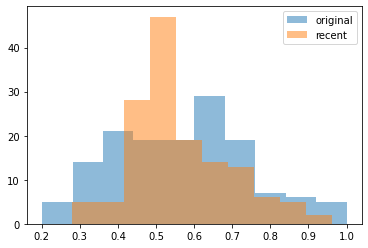

In [57]:
plt.hist(np.sort(textdf6['originalVD']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentVD']), alpha = 0.5, label = 'recent')
plt.legend()

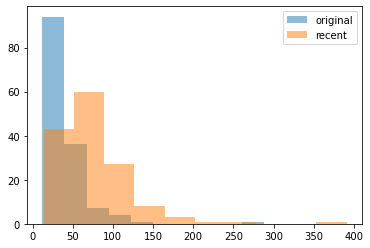

In [54]:
plt.hist(np.sort(textdf6['originalWPS']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPS']), alpha = 0.5, label = 'recent')
plt.legend()

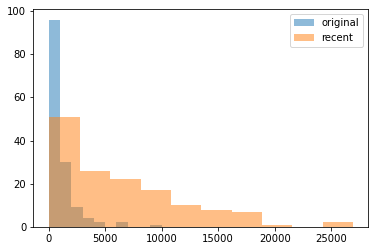

In [56]:
plt.hist(np.sort(textdf6['originalWPT']), alpha = 0.5, label = 'original')
plt.hist(np.sort(textdf6['recentWPT']), alpha = 0.5, label = 'recent')
plt.legend()

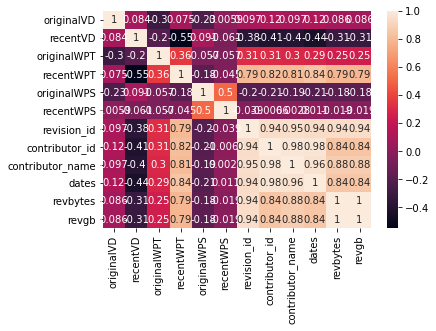

In [46]:
corrMatrix = textdf6.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

NLP Playground...

In [61]:
textdf6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_title        144 non-null    object 
 1   original          144 non-null    object 
 2   recent            144 non-null    object 
 3   originalVD        144 non-null    float64
 4   recentVD          144 non-null    float64
 5   originalWPT       144 non-null    int64  
 6   recentWPT         144 non-null    int64  
 7   originalWPS       143 non-null    float64
 8   recentWPS         144 non-null    float64
 9   revision_id       141 non-null    float64
 10  contributor_id    141 non-null    float64
 11  contributor_name  141 non-null    float64
 12  dates             141 non-null    float64
 13  revbytes          141 non-null    float64
 14  revgb             141 non-null    float64
dtypes: float64(10), int64(2), object(3)
memory usage: 18.0+ KB


In [62]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [63]:
def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers.
        text (str): input text
    return (str): modified initial text
    """
    text = text.lower()  # lowercase text
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text



In [64]:
clean = []

for i in textdf6['recent']:
    clean.append(clean_text(i))

In [69]:
textdf6['cleantext'] = clean
textdf6['cleantext'].head()

0    for other uses see anarchism  disambiguation  ...
1    this article is about the classic autistic dis...
2    for other uses see albedo  disambiguation  the...
3    this article is about the roman letter for oth...
4    this article is about the u s state for the ri...
Name: cleantext, dtype: object

In [73]:
def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    """
    Lemmatize, tokenize, crop and remove stop words.
    """
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words and w not in stopwords)]
    return tokens    


In [74]:
toks = []

for i in textdf6['cleantext']:
    toks.append(tokenizer(i))

In [75]:
textdf6['tokenized'] = toks
textdf6['tokenized'].head()

0    [for, other, us, see, anarchism, disambiguatio...
1    [this, article, is, about, the, classic, autis...
2    [for, other, us, see, albedo, disambiguation, ...
3    [this, article, is, about, the, roman, letter,...
4    [this, article, is, about, the, u, s, state, f...
Name: tokenized, dtype: object

In [76]:
def clean_sentences(df):
    """
    Remove irrelavant characters (in new column clean_text).
    Lemmatize, tokenize words into list of words (in new column tokenized).
    """
    print('Cleaning sentences...')
    df['clean_text'] = df['recent'].apply(clean_text)
    df['tokenized'] = df['clean_text'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True))
    return df
    


In [77]:
textdf7 = clean_sentences(textdf6)
textdf7.head()

Cleaning sentences...


page_title                                           original  \
0  Anarchism  Anarchism is a name taken by various political...   
1     Autism  Autism is a complex pervasive developmental di...   
2     Albedo  In climatology,the albedo of a surface is the ...   
3          A  The letter A is the first letter in the Roman ...   
4    Alabama  Alternate meanings: See Alabama (disambiguatio...   

                                              recent  originalVD  recentVD  \
0  For other uses,see Anarchism (disambiguation)....    0.667939  0.489255   
1  This article is about the classic autistic dis...    0.398438  0.499190   
2  For other uses,see Albedo (disambiguation).The...    0.568889  0.440594   
3  This article is about the Roman letter.For oth...    0.538071  0.471910   
4  This article is about the U.S.state.For the ri...    0.638889  0.456440   

   originalWPT  recentWPT  originalWPS   recentWPS  revision_id  \
0         1733      10518    32.326923   25.161692      19961.0   
1          857       7320    25.781250   84.116279      10646.0   
2         1426       4152    51.777778  152.777778       1253.0   
3         1527       2386    33.681818   25.208791       4802.0   
4          491      13683    13.441176   93.358621      10202.0   

   contributor_id  contributor_name   dates      revbytes     revgb  \
0          3797.0            1918.0  3216.0  1.689955e+09  1.689955   
1          3757.0            1885.0  2537.0  9.503834e+08  0.950383   
2           701.0             448.0   731.0  3.025434e+07  0.030254   
3          2609.0            1448.0  1489.0  4.717380e+07  0.047174   
4          4485.0            2260.0  3119.0  1.130464e+09  1.130464   

                                           cleantext  \
0  for other uses see anarchism  disambiguation  ...   
1  this article is about the classic autistic dis...   
2  for other uses see albedo  disambiguation  the...   
3  this article is about the roman letter for oth...   
4  this article is about the u s state for the ri...   

                                           tokenized  \
0  [for, other, us, see, anarchism, disambiguatio...   
1  [this, article, is, about, the, classic, autis...   
2  [for, other, us, see, albedo, disambiguation, ...   
3  [this, article, is, about, the, roman, letter,...   
4  [this, article, is, about, the, u, s, state, f...   

                                          clean_text  
0  for other uses see anarchism  disambiguation  ...  
1  this article is about the classic autistic dis...  
2  for other uses see albedo  disambiguation  the...  
3  this article is about the roman letter for oth...  
4  this article is about the u s state for the ri...

In [78]:
query_sentence = 'a land in south africa' 

pd.options.display.max_colwidth = 500

In [80]:
def extract_best_indices(m, topk, mask=None):
    """
    Use sum of the cosine distance over all tokens.
    m (np.array): cos matrix of shape (nb_in_tokens, nb_dict_tokens)
    topk (int): number of indices to return (from high to lowest in order)
    """
    # return the sum on all tokens of cosinus for each sentence
    if len(m.shape) > 1:
        cos_sim = np.mean(m, axis=0) 
    else: 
        cos_sim = m
    index = np.argsort(cos_sim)[::-1] # from highest idx to smallest score 
    if mask is not None:
        assert mask.shape == m.shape
        mask = mask[index]
    else:
        mask = np.ones(len(cos_sim))
    mask = np.logical_or(cos_sim[index] != 0, mask) #eliminate 0 cosine distance
    best_index = index[mask][:topk]  
    return best_index

In [87]:
extract_best_indices(textdf7['clean_text'],3)

143    82
142    19
141     4
Name: clean_text, dtype: int64

In [89]:
# Adapt stop words
token_stop = tokenizer(' '.join(STOPWORDS), lemmatize=False)

# Fit TFIDF
vectorizer = TfidfVectorizer(stop_words=token_stop, tokenizer=tokenizer) 
tfidf_mat = vectorizer.fit_transform(textdf7['cleantext'].values) # -> (num_sentences, num_vocabulary)
tfidf_mat.shape

C:\Users\ninap\miniconda3\envs\dmml\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(


(144, 54556)

In [90]:
query_sentence

'a land in south africa'

In [91]:
def get_recommendations_tfidf(sentence, tfidf_mat):
    
    """
    Return the database sentences in order of highest cosine similarity relatively to each 
    token of the target sentence. 
    """
    # Embed the query sentence
    tokens = [str(tok) for tok in tokenizer(sentence)]
    vec = vectorizer.transform(tokens)
    # Create list with similarity between query and dataset
    mat = cosine_similarity(vec, tfidf_mat)
    # Best cosine distance for each token independantly
    print(mat.shape)
    best_index = extract_best_indices(mat, topk=3)
    return best_index


In [92]:
best_index = get_recommendations_tfidf(query_sentence, tfidf_mat)

textdf7[['page_title', 'cleantext']].iloc[best_index].head()

(5, 144)


page_title  \
76               Atlantic Ocean   
84  Foreign relations of Angola   
72                         Asia   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              cleantext  
76  atlantic north atlantic south atlantic and atlantic basin redirect here for other uses see atlantic  disambiguation  north atlantic  disambiguation  south atlantic  disambiguation  and atlantic basin  disambiguation  play media this video was taken by the crew of expedition 29 on board the iss the pass starts from just northeast of the island of newfoundland over the north atlantic ocean to central africa over south sudan the atlantic ocean is the second largest of the world  five oceans wit...  
84  the foreign relations of angola are based on angola  strong support of u s foreign policy as the angolan economy is dependent on u s foreign aid from 1975 to 1989 angola was aligned with the eastern bloc in particular the soviet union libya  citation needed  and cuba since then it has focused on improving relationships with western countries cultivating links with other portuguese speaking countries and asserting its own national interests in central africa through military and diplomatic in...  
72  this article is about the continent for other uses see asia  disambiguation  map of the most populous part of asia showing physical political and population characteristics as per 2018asia   ˈeɪʒə ˈeɪʃə   listen   is earth  largest and most populous continent located primarily in the eastern and northern hemispheres it shares the continental landmass of eurasia with the continent of europe and the continental landmass of afro eurasia with africa and europe asia covers an area of 44 579 000 s...

transformer version

In [94]:
from sentence_transformers import SentenceTransformer, util
import torch

In [102]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
corpus_embeddings = model.encode(textdf7.cleantext.values, convert_to_tensor=True)
query_embedding = model.encode(query_sentence, convert_to_tensor=True)

cos_scores = util.pytorch_cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=3)

print("\n\n======================\n\n")
print("Query:", query_sentence)
print("\nmost similar sentences in corpus:")

for score, idx in zip(top_results[0], top_results[1]):
    score = score.cpu().data.numpy() 
    idx = idx.cpu().data.numpy()
    print(textdf7[['page_title', 'cleantext']].iloc[idx].head())





Query: a land in south africa

most similar sentences in corpus:
page_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Algeria
cleantext     this article is about the country for other uses see algeria  disambiguation  algeria  c  officially the people  democratic republic of algeria is a country in the maghreb region of north africa the country is the largest country by total area in africa and in the arab world and is bordered to the northeast by tunisia  to the east by libya  to the southeast by niger  to the southwest by mali mauritan

In [166]:
print(wikipedia.page("Anarchism").categories)

['Anarchism', 'Anti-capitalism', 'Anti-fascism', 'Articles containing French-language text', 'Articles containing Spanish-language text', 'Articles prone to spam from November 2014', 'Articles with BNE identifiers', 'Articles with BNF identifiers', 'Articles with EMU identifiers', 'Articles with GND identifiers', 'Articles with HDS identifiers', 'Articles with J9U identifiers', 'Articles with LCCN identifiers', 'Articles with NKC identifiers', 'Articles with short description', 'Economic ideologies', 'Far-left politics', 'Good articles', 'Left-wing politics', 'Libertarian socialism', 'Libertarianism', 'Political culture', 'Political ideologies', 'Political movements', 'Short description matches Wikidata', 'Social theories', 'Socialism', 'Use British English from August 2021', 'Use dmy dates from August 2021', 'Wikipedia indefinitely semi-protected pages']


In [211]:
df.head()

page_id           page_title  revision_id            timestamp  \
0       10  AccessibleComputing       233192  2001-01-21 02:12:21   
1       10  AccessibleComputing       862220  2002-02-25 15:43:11   
2       10  AccessibleComputing     15898945  2003-04-25 22:18:38   
3       10  AccessibleComputing     56681914  2006-06-03 16:55:41   
4       10  AccessibleComputing     74466685  2006-09-08 04:16:04   

                comment contributor_id   contributor_name  bytes  \
0                     *             99          RoseParks    124   
1  Automated conversion        1226483  Conversion script     35   
2       Fixing redirect           7543              Ams80     34   
3   fix double redirect         516514                Nzd     36   
4                cat rd         750223            Rory096     57   

                                                                                                         revtext  \
0  This subject covers* AssistiveTechnology* AccessibleSoftware* AccessibleWeb* LegalIssuesInAccessibleComputing   
1                                                                             #REDIRECT [[Accessible Computing]]   
2                                                                             #REDIRECT [[Accessible_computing]]   
3                                                                           #REDIRECT [[Computer accessibility]]   
4                                                      #REDIRECT [[Computer accessibility]] {{R from CamelCase}}   

        dates     times  revbytes   revperc  
0  2001-01-21  02:12:21      2848  4.353933  
1  2002-02-25  15:43:11      2848  1.228933  
2  2003-04-25  22:18:38      2848  1.193820  
3  2006-06-03  16:55:41      2848  1.264045  
4  2006-09-08  04:16:04      2848  2.001404

In [217]:
textdf7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_title        144 non-null    object 
 1   original          144 non-null    object 
 2   recent            144 non-null    object 
 3   originalVD        144 non-null    float64
 4   recentVD          144 non-null    float64
 5   originalWPT       144 non-null    int64  
 6   recentWPT         144 non-null    int64  
 7   originalWPS       143 non-null    float64
 8   recentWPS         144 non-null    float64
 9   revision_id       141 non-null    float64
 10  contributor_id    141 non-null    float64
 11  contributor_name  141 non-null    float64
 12  dates             141 non-null    float64
 13  revbytes          141 non-null    float64
 14  revgb             141 non-null    float64
 15  cleantext         144 non-null    object 
 16  tokenized         144 non-null    object 
 1

In [222]:
textdf8 = pd.merge(textdf7, df1[['page_title', 'page_id']], on='page_title', how='left')
textdf8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_title        144 non-null    object 
 1   original          144 non-null    object 
 2   recent            144 non-null    object 
 3   originalVD        144 non-null    float64
 4   recentVD          144 non-null    float64
 5   originalWPT       144 non-null    int64  
 6   recentWPT         144 non-null    int64  
 7   originalWPS       143 non-null    float64
 8   recentWPS         144 non-null    float64
 9   revision_id       141 non-null    float64
 10  contributor_id    141 non-null    float64
 11  contributor_name  141 non-null    float64
 12  dates             141 non-null    float64
 13  revbytes          141 non-null    float64
 14  revgb             141 non-null    float64
 15  cleantext         144 non-null    object 
 16  tokenized         144 non-null    object 
 1

save progress to csv

In [267]:
textdf8.to_csv('p1p857_Text.csv')

play with categories...

In [179]:
cats = []

try:
    for i in textdf7['page_title']:
        cats.append(wikipedia.page(i).categories)
except wikipedia.exceptions.PageError:
    #print(i)
    pass
    



In [228]:
wikipedia.page(title = 'AccessibleComputing', pageid = 10).categories

['All articles needing additional references',
 'All articles with unsourced statements',
 'All pages needing cleanup',
 'Articles needing additional references from May 2010',
 'Articles needing cleanup from September 2012',
 'Articles with hAudio microformats',
 'Articles with multiple maintenance issues',
 'Articles with short description',
 'Articles with unsourced statements from January 2022',
 'CS1 Portuguese-language sources (pt)',
 'Cleanup tagged articles with a reason field from September 2012',
 'Commons category link from Wikidata',
 'Computer accessibility',
 'Short description matches Wikidata',
 'Spoken articles',
 'Webarchive template other archives',
 'Webarchive template wayback links',
 'Wikipedia pages needing cleanup from September 2012']

In [232]:
cats = []
Perror = []
Derror = []

for i in textdf7['page_title']:
    try:
        cats.append(wikipedia.page(i).categories)
    except wikipedia.exceptions.PageError:
        Perror.append(i)
        pass
    except wikipedia.exceptions.DisambiguationError: 
        Derror.append(i)
        pass


C:\Users\ninap\miniconda3\envs\dmml\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\ninap\miniconda3\envs\dmml\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [236]:
Perror

['Autism',
 'Ayn Rand',
 'Animal Farm',
 'A Modest Proposal',
 'Asia',
 'Asteroids (video game)',
 'Altaic languages',
 'Axiom of choice',
 'Alfred Nobel',
 'Apple Inc.']

In [237]:
def getURL(keyword):
  S = requests.Session()
  URL = "https://en.wikipedia.org/w/api.php"
  PARAMS = {
    "action": "opensearch",
    "search": keyword,
    "limit": "1",
    "format": "json", 
    'profile': 'fuzzy'
    }
  R = S.get(url=URL, params=PARAMS)
  got = R.json()
  wikititle = got[3]
  wt1 = ''.join(str(e) for e in wikititle)
  print(wt1)
  return wt1

In [255]:
def getCat(keyword):
  S = requests.Session()
  URL = "https://en.wikipedia.org/w/api.php"
  PARAMS = {
      "action": "query",
      "format": "json",
      "prop": "categories",
      "titles": keyword
      }
  R = S.get(url=URL, params=PARAMS)
  DATA = R.json()

  PAGES = DATA["query"]["pages"]

  cats = []
  pages = []

  for k, v in PAGES.items():
    for cat in v['categories']:
        cats.append(cat["title"]) 
        pages.append(keyword)
  return cats, pages

In [ ]:
perrortitles = []
perrorcats = []

for i in Perror: 
    perrortitles.append(getCat(i)['pages'])
    perrorcats.append(getCat(i)['cats'][1])



In [262]:
pages

['titles',
 'titles',
 'titles',
 'titles',
 'titles',
 'titles',
 'titles',
 'titles',
 'titles',
 'titles']

In [241]:
for i in Derror: 
    getURL(i)

https://en.wikipedia.org/wiki/Alien
https://en.wikipedia.org/wiki/ASCII
https://en.wikipedia.org/wiki/Abel
https://en.wikipedia.org/wiki/Aa_River
https://en.wikipedia.org/wiki/Alberta
https://en.wikipedia.org/wiki/Allahabad
https://en.wikipedia.org/wiki/Art
https://en.wikipedia.org/wiki/Asterism
https://en.wikipedia.org/wiki/Audi


In [ ]:
def getcat(keyword):

    S = requests.Session()

    URL = "https://en.wikipedia.org/w/api.php"

    PARAMS = {
        "action": "query",
        "format": "json",
        "prop": "categories",
        "titles": keyword,
        "clshow": "!hidden"
    }

    R = S.get(url=URL, params=PARAMS)
    DATA = R.json()

    PAGES = DATA["query"]["pages"]
    cates = []
    for k, v in PAGES.items():
        try:
            for cat in v['categories']:
                cates.append(cat["title"])
        except:
            cates.append('no cat')

    return cates